In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import optuna

In [20]:
# Load the Dataset
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['MedHouseVal'] = housing.target

In [21]:
print(data.isnull().sum())
print(data.describe())

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000

In [22]:
X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal'] #Target feature

In [23]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

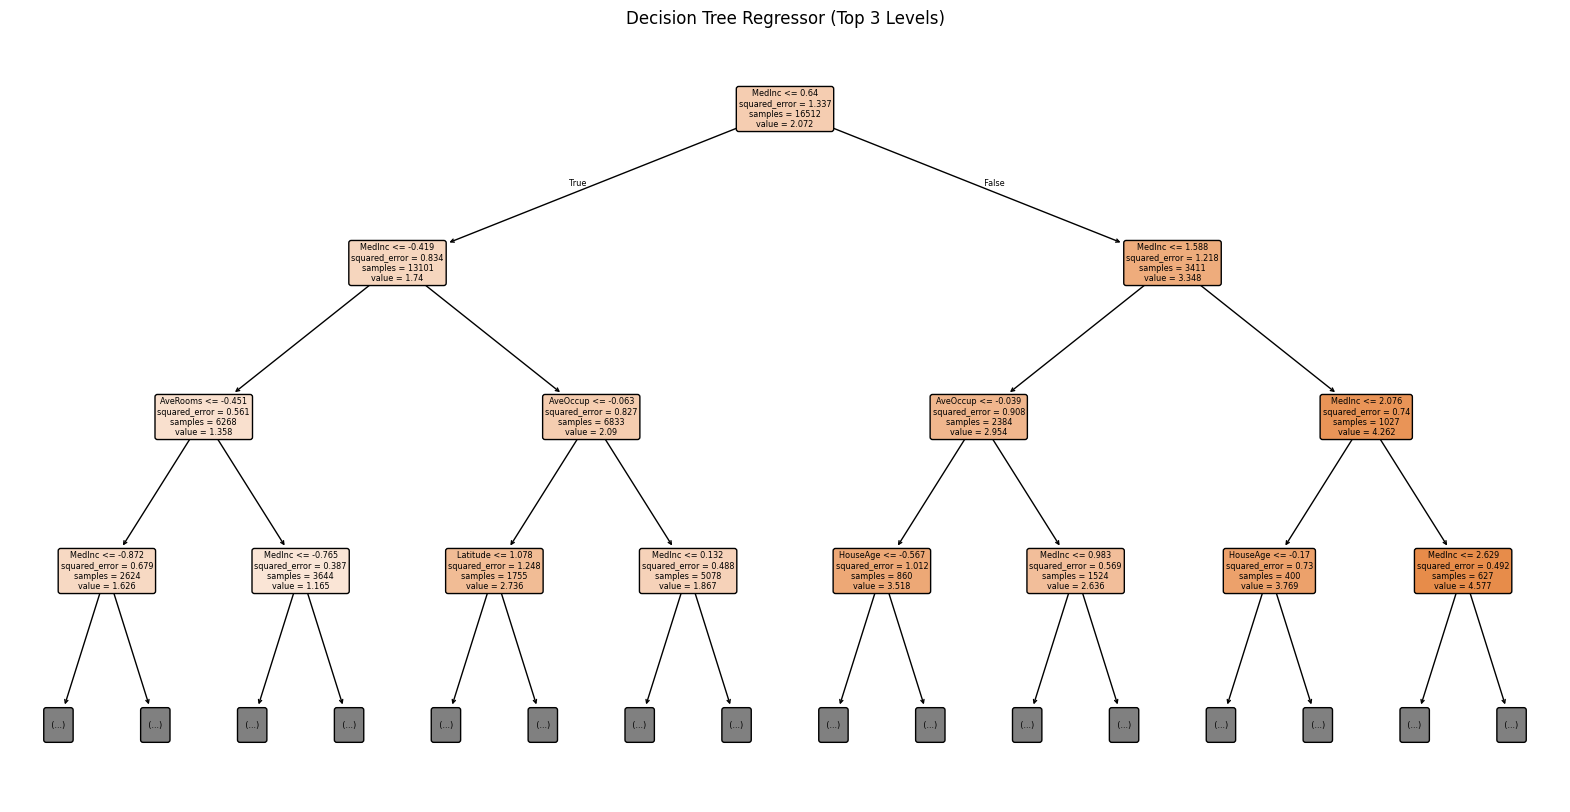

In [26]:
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=housing.feature_names, filled=True, rounded=True, max_depth=3)
plt.title('Decision Tree Regressor (Top 3 Levels)')
plt.show()

In [27]:
y_pred = dt_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Initial Mean Squared Error: {mse}')
print(f'Initial R-squared: {r2}')

Initial Mean Squared Error: 0.4942716777366763
Initial R-squared: 0.6228111330554302


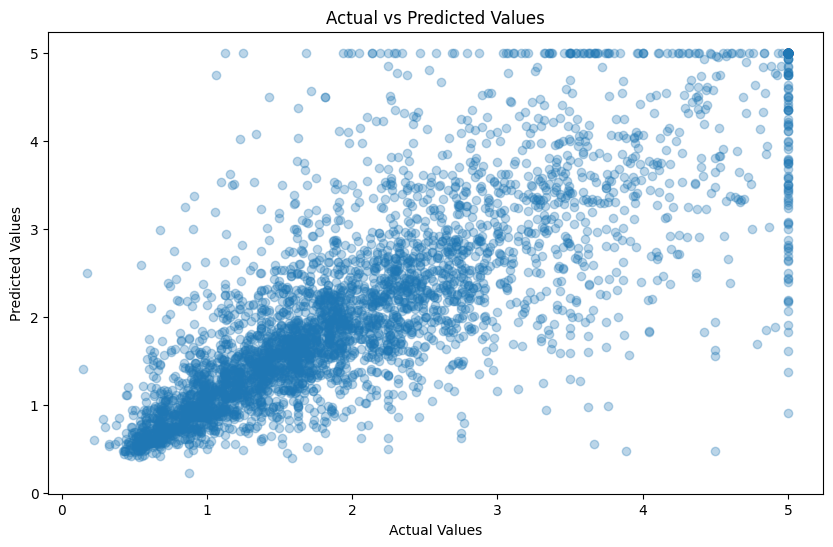

In [40]:
#GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters from GridSearchCV: {'ccp_alpha': 0.0, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [30]:

best_dt_regressor = grid_search.best_estimator_
best_dt_regressor.fit(X_train, y_train)
y_pred_best = best_dt_regressor.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Improved Mean Squared Error (GridSearchCV): {mse_best}')
print(f'Improved R-squared (GridSearchCV): {r2_best}')

Improved Mean Squared Error (GridSearchCV): 0.36409983982859495
Improved R-squared (GridSearchCV): 0.7221479355877394


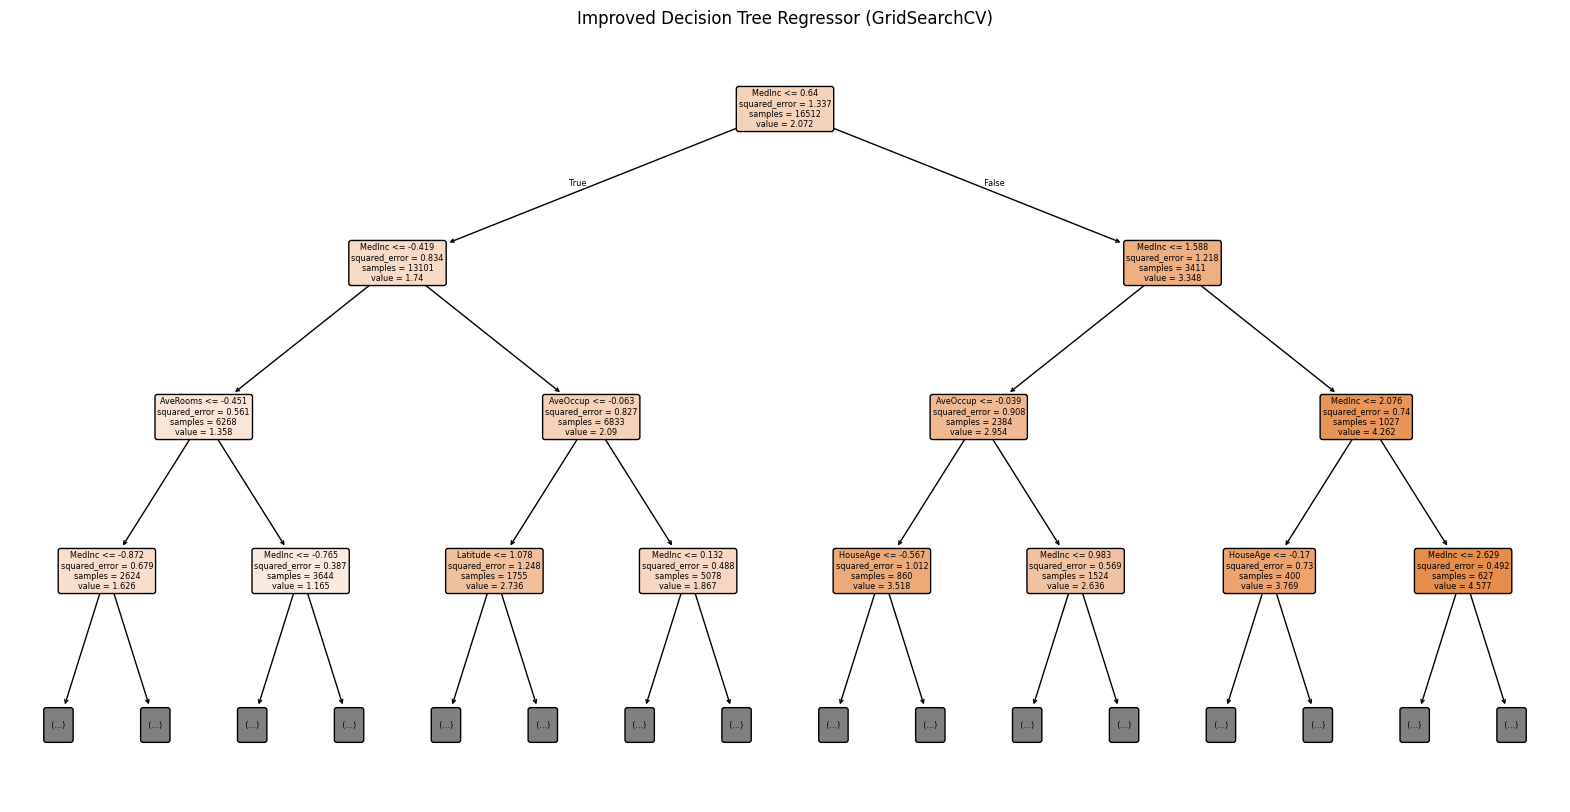

In [31]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt_regressor, feature_names=housing.feature_names, filled=True, rounded=True, max_depth=3)
plt.title('Improved Decision Tree Regressor (GridSearchCV)')
plt.show()

In [32]:
#RandomizedSearchCV
param_distributions = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}
random_search = RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=42), 
                                   param_distributions=param_distributions, 
                                   n_iter=100, cv=3, random_state=42, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)
print(f'Best parameters from RandomizedSearchCV: {random_search.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters from RandomizedSearchCV: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None, 'ccp_alpha': 0.0}


In [33]:
#Optuna
def optuna_objective(trial):
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'ccp_alpha': trial.suggest_uniform('ccp_alpha', 0.0, 0.1)
    }
    regressor = DecisionTreeRegressor(**params, random_state=42)
    scores = cross_val_score(regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()

In [39]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(optuna_objective, n_trials=100)
print(f'Best parameters from Optuna: {study.best_trial.params}')

[I 2024-05-31 17:14:27,227] A new study created in memory with name: no-name-1d9f1ccc-de08-4745-9900-b5a75380e361
C:\Users\marci\AppData\Local\Temp\ipykernel_4176\2366388282.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'ccp_alpha': trial.suggest_uniform('ccp_alpha', 0.0, 0.1)
[I 2024-05-31 17:14:27,369] Trial 0 finished with value: 0.8969385835119583 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'ccp_alpha': 0.07080725777960455}. Best is trial 0 with value: 0.8969385835119583.
C:\Users\marci\AppData\Local\Temp\ipykernel_4176\2366388282.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'ccp_alpha': trial.suggest_uniform('ccp_alpha', 0.0, 0

Best parameters from Optuna: {'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'ccp_alpha': 9.321865889568576e-05}


In [35]:
# Cross-Validation
cross_val_scores = cross_val_score(best_dt_regressor, X_scaled, y, cv=5)
print(f'Cross-Validation Scores: {cross_val_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cross_val_scores)}')

Cross-Validation Scores: [0.38007646 0.56275993 0.6224191  0.54448933 0.59609098]
Mean Cross-Validation Score: 0.541167158608949


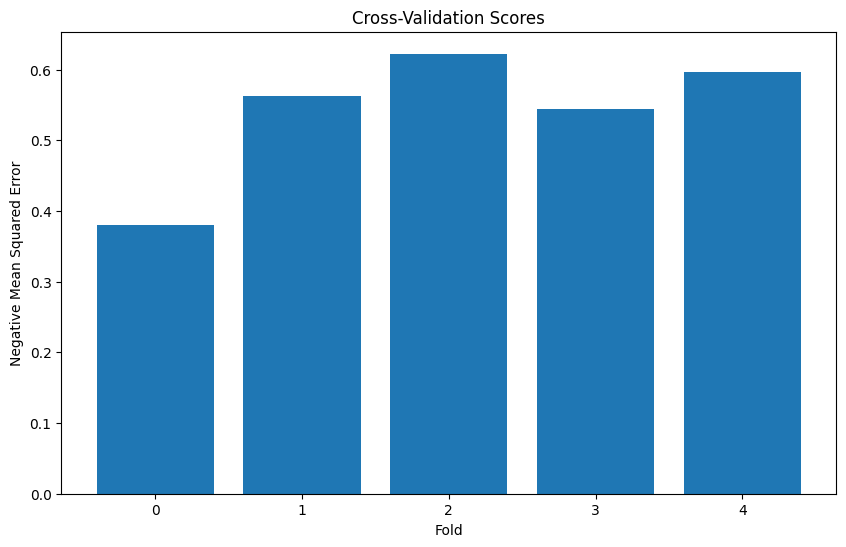

In [36]:
#Cross-Validation Results
plt.figure(figsize=(10, 6))
plt.bar(range(len(cross_val_scores)), cross_val_scores)
plt.xlabel('Fold')
plt.ylabel('Negative Mean Squared Error')
plt.title('Cross-Validation Scores')
plt.show()